# Práctica Calificada 1 - Grupo 2: Análisis de Series de Tiempo

**Objetivo:** Este notebook contiene el pipeline de preprocesamiento y el análisis exploratorio de datos (EDA) para el dataset de transacciones de Google Analytics, agregado por Día y Producto.

## Parte 1: Carga y Preprocesamiento de Datos

### 1.1. Importar Librerías y Módulos

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from IPython.display import display

# Añadir el directorio raíz del proyecto al path para importar nuestros módulos
project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

from src.preprocess.cleaning import clean_data
from src.preprocess.aggregation import aggregate_data_by_product

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 8)

print("Librerías y módulos cargados exitosamente.")

Librerías y módulos cargados exitosamente.


### 1.2. Cargar Datos Crudos

In [14]:
RAW_DATA_PATH = project_root / 'data' / 'raw' / 'data_sample.parquet'
df_raw = pd.read_parquet(RAW_DATA_PATH)
print(f"Dataset crudo cargado. Forma: {df_raw.shape}")

Dataset crudo cargado. Forma: (74457, 77)


### 1.3. Análisis Inicial del Dataset Crudo

Antes de cualquier transformación, es fundamental entender la estructura y contenido de nuestros datos crudos.

In [15]:
print("\nInformación general del dataset crudo:")
df_raw.info()

print("\nEstadísticas descriptivas numéricas:")
display(df_raw.describe())

print("\nEstadísticas categóricas (conteos/top):")
display(df_raw.describe(include=['object', 'category']))

# Identificación de tipos
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_raw.select_dtypes(include=['object', 'category']).columns.tolist()
dt_cols = df_raw.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()

print(f"\nColumnas numéricas ({len(numeric_cols)}): {numeric_cols[:10]}...")
print(f"Columnas categóricas ({len(cat_cols)}): {cat_cols[:10]}...")
print(f"Columnas datetime ({len(dt_cols)}): {dt_cols}")


Información general del dataset crudo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74457 entries, 0 to 74456
Data columns (total 77 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_date          74457 non-null  object 
 1   parsed_date               74457 non-null  object 
 2   transaction_id            74457 non-null  object 
 3   transaction_revenue_usd   36744 non-null  float64
 4   transaction_tax_usd       25581 non-null  float64
 5   transaction_shipping_usd  36580 non-null  float64
 6   transaction_affiliation   74457 non-null  object 
 7   currency_code             74457 non-null  object 
 8   product_sku               74457 non-null  object 
 9   product_name              74457 non-null  object 
 10  product_category          74457 non-null  object 
 11  product_brand             74457 non-null  object 
 12  product_variant           74457 non-null  object 
 13  product_quantity     

,transaction_revenue_usd,transaction_tax_usd,transaction_shipping_usd,product_quantity,product_price_usd,product_revenue_usd,session_id,session_number,session_start_time,total_visits,...,bounces,new_visits,adwords_campaign_id,adwords_adgroup_id,adwords_creative_id,adwords_criteria_id,hit_number,hit_time_ms,hit_hour,hit_minute
count,36744.000000,25581.000000,36580.000000,36818.000000,74457.000000,36818.000000,7.445700e+04,74457.000000,7.445700e+04,74457.0,...,0.0,25663.0,0.0,0.0,0.0,0.0,74457.000000,7.445700e+04,74457.000000,74457.000000
mean,287.388543,22.767936,22.977237,6.413955,16.629624,47.315090,1.485686e+09,5.257195,1.485686e+09,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,50.918947,1.301840e+06,12.816498,30.120781
std,1028.358260,31.563780,51.020311,25.597807,18.680915,159.042538,9.543476e+06,17.357087,9.543475e+06,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,43.281128,1.129644e+06,4.817902,17.053834
min,1.200000,1.260000,7.000000,1.000000,0.790000,0.895263,1.470046e+09,1.000000,1.470046e+09,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,1.000000,0.000000e+00,0.000000,0.000000
25%,46.960000,8.950000,10.000000,1.000000,3.990000,11.666666,1.477427e+09,1.000000,1.477427e+09,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,24.000000,5.740900e+05,9.000000,16.000000
50%,96.900000,13.110000,13.000000,1.000000,13.290000,19.571666,1.485377e+09,2.000000,1.485377e+09,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,40.000000,9.759760e+05,12.000000,30.000000
75%,230.870000,24.290000,15.500000,3.000000,18.990000,41.590000,1.494011e+09,5.000000,1.494011e+09,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,63.000000,1.654684e+06,16.000000,45.000000
max,23952.560000,763.140000,1138.740000,1000.000000,250.000000,9496.000000,1.501652e+09,315.000000,1.501652e+09,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,490.000000,1.504662e+07,23.000000,59.000000



Estadísticas categóricas (conteos/top):


,transaction_date,parsed_date,transaction_id,transaction_affiliation,currency_code,product_sku,product_name,product_category,product_brand,product_variant,...,ad_network_type,is_entrance,is_exit,referer,page_path,hostname,page_title,entrance_page_path,exit_page_path,social_engagement_type
count,74457,74457,74457,74457,74457,74457,74457,74457,74457,74457,...,2832,10,26941,0,74457,74457,74457,22,56761,74457
unique,365,365,11551,1,1,1122,490,21,1,35,...,1,1,1,0,1,1,5,1,1,1
top,20161212,2016-12-12,ORD201703041515,Google Merchandise Store,USD,GGOEGFKQ020399,Google Sunglasses,Apparel,(not set),Single Option Only,...,Google Search,True,True,NaN,/ordercompleted.html,shop.googlemerchandisestore.com,Checkout Confirmation,/ordercompleted.html,/ordercompleted.html,Not Socially Engaged
freq,550,550,146,74457,74457,1590,2756,26276,74457,35178,...,2832,10,26941,NaN,74457,74457,74441,22,56761,74457



Columnas numéricas (23): ['transaction_revenue_usd', 'transaction_tax_usd', 'transaction_shipping_usd', 'product_quantity', 'product_price_usd', 'product_revenue_usd', 'session_id', 'session_number', 'session_start_time', 'total_visits']...
Columnas categóricas (52): ['transaction_date', 'parsed_date', 'transaction_id', 'transaction_affiliation', 'currency_code', 'product_sku', 'product_name', 'product_category', 'product_brand', 'product_variant']...
Columnas datetime (0): []


### 1.4. Limpieza, Agregación y Guardado de Datos

Aplicamos las funciones de `cleaning.py` y `aggregation.py` para procesar los datos y los guardamos en la carpeta `processed`.

In [16]:
print("Iniciando pipeline de preprocesamiento...")
df_cleaned = clean_data(df_raw.copy())
df_aggregated = aggregate_data_by_product(df_cleaned.copy())

# Guardar los datos procesados
PROCESSED_DATA_PATH = project_root / 'data' / 'processed' / 'group2_data.parquet'
PROCESSED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
df_aggregated.to_parquet(PROCESSED_DATA_PATH, index=False)
print(f"Datos procesados y guardados en: {PROCESSED_DATA_PATH}")

Iniciando pipeline de preprocesamiento...


E:\DOCUMENTOS\UPC\UPC 05\Data Science\PC1\pc1_20252_metodologia_data_science\src\preprocess\cleaning.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('unknown', inplace=True)


Datos procesados y guardados en: E:\DOCUMENTOS\UPC\UPC 05\Data Science\PC1\pc1_20252_metodologia_data_science\data\processed\group2_data.parquet


## Parte 2: Análisis Exploratorio de Series de Tiempo (EDA)

In [17]:
# Cargar el dataset procesado para el análisis
df = pd.read_parquet(PROCESSED_DATA_PATH)
print(f"Dataset procesado cargado. Forma: {df.shape}")
df.head()

Dataset procesado cargado. Forma: (28322, 6)


,transaction_date,product_sku,total_product_quantity,total_product_revenue_usd,avg_product_price_usd,total_transactions
0,2016-08-01,GGOEAAXN066355,1.0,15.090000,13.59,1
1,2016-08-01,GGOEADHH015499,30.0,576.033333,19.19,1
2,2016-08-01,GGOEADHJ015599,30.0,576.033333,19.19,1
3,2016-08-01,GGOEADWQ015699,25.0,265.711904,11.69,2
4,2016-08-01,GGOEGAAB010516,1.0,17.101111,16.99,1


### 2.1. Análisis General de Ingresos

Primero, analizamos la serie de tiempo de los ingresos totales por día para identificar patrones generales.

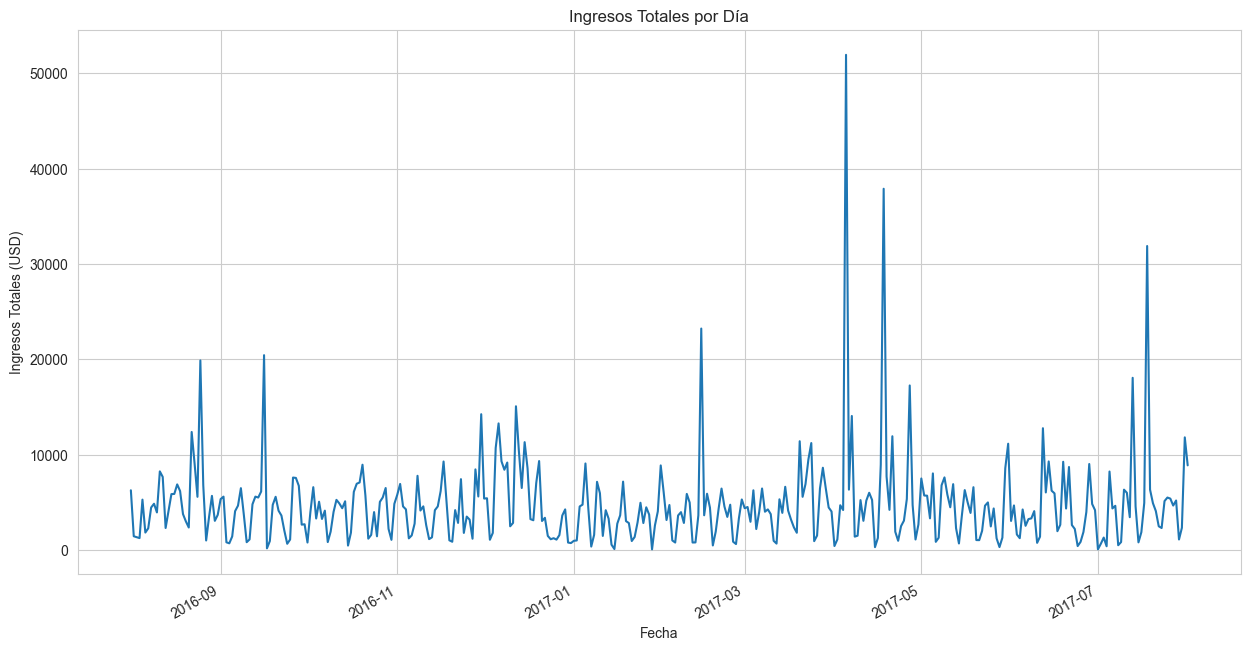

In [18]:
# Agrupar por fecha para obtener la serie de tiempo de ingresos totales
daily_revenue = df.groupby('transaction_date')['total_product_revenue_usd'].sum()

# Graficar la serie de tiempo
daily_revenue.plot(title='Ingresos Totales por Día')
plt.xlabel('Fecha')
plt.ylabel('Ingresos Totales (USD)')
plt.show()

### 2.2. Descomposición de la Serie de Tiempo

Descomponemos la serie de ingresos diarios para observar sus componentes principales: tendencia, estacionalidad y residuos.

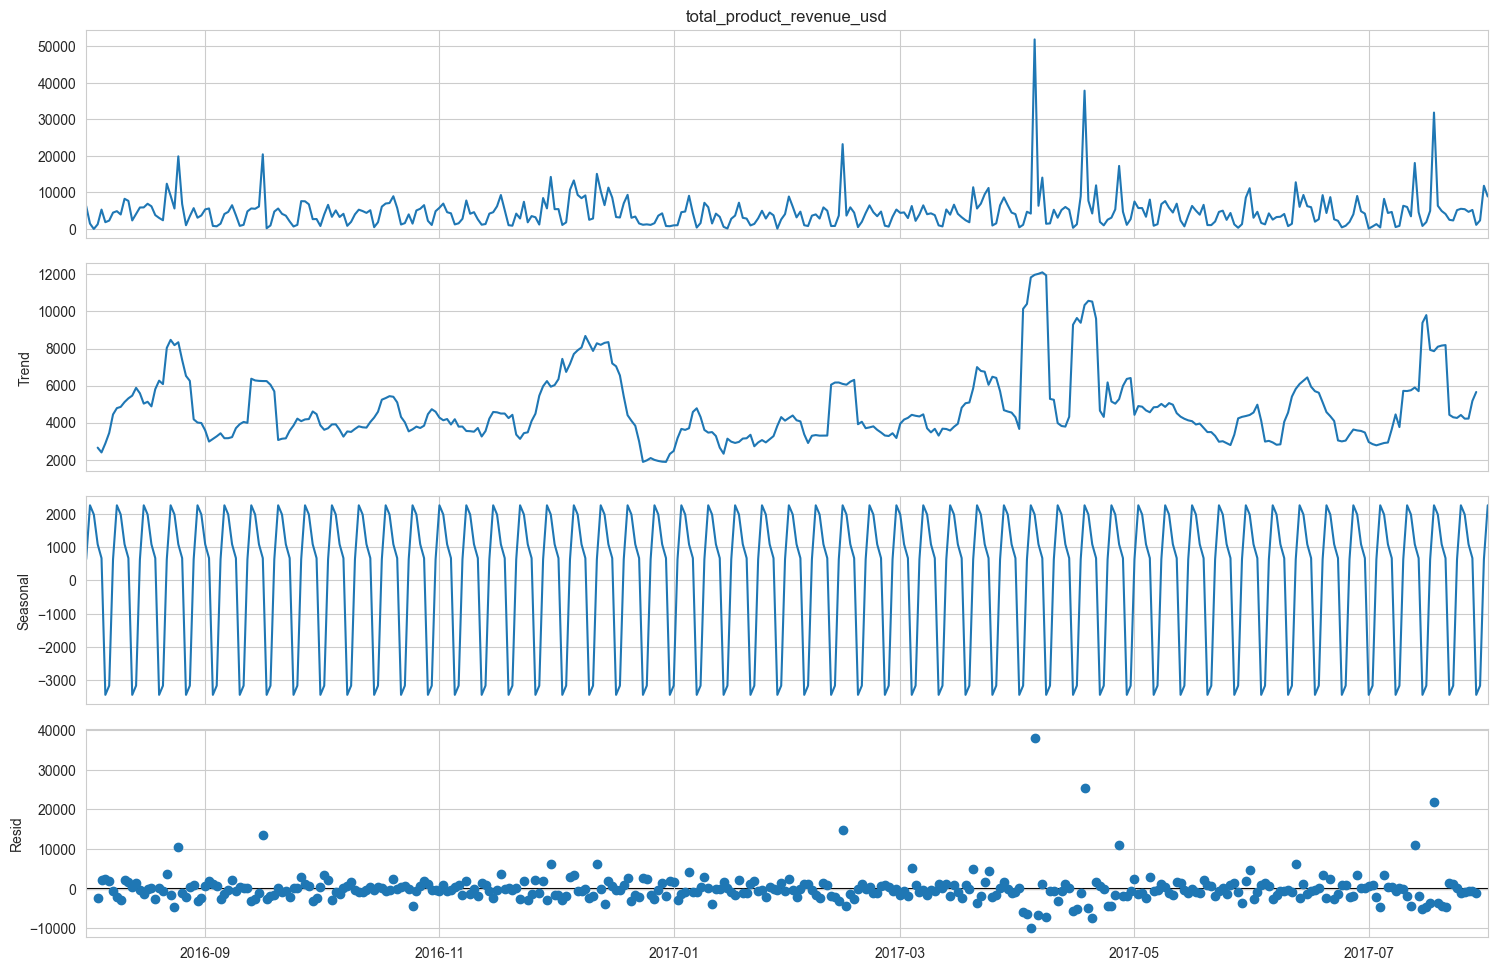

In [19]:
# La descomposición requiere que el índice sea la fecha
ts_revenue = daily_revenue.asfreq('D').fillna(0) # Asegurar frecuencia diaria y rellenar huecos

decomposition = sm.tsa.seasonal_decompose(ts_revenue, model='additive', period=7) # Asumimos estacionalidad semanal

fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()

### 2.3. Test de Estacionariedad (Augmented Dickey-Fuller Test)

Verificamos formalmente si la serie de ingresos es estacionaria. Una serie es estacionaria si su media, varianza y covarianza son constantes en el tiempo. Esto es un supuesto clave para muchos modelos de series de tiempo.

- **Hipótesis Nula (H0):** La serie tiene una raíz unitaria (no es estacionaria).
- **Hipótesis Alternativa (H1):** La serie es estacionaria.

In [20]:
def adf_test(timeseries, title=''):
    """
    Realiza el test de Dickey-Fuller Aumentado e interpreta los resultados.
    """
    print(f'Resultados del Test de Dickey-Fuller para {title}:')
    print('-' * 50)
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
        'Estadístico ADF',
        'p-value',
        'Lags utilizados',
        'Número de observaciones'
    ])
    
    for key, value in dftest[4].items():
        dfoutput[f'Valor crítico ({key})'] = value
    
    print(dfoutput)
    print()
    
    if dftest[1] <= 0.05:
        print(f"✅ RESULTADO: Rechazamos H0 (p-value: {dftest[1]:.4f}). La serie ES ESTACIONARIA.")
    else:
        print(f"❌ RESULTADO: No rechazamos H0 (p-value: {dftest[1]:.4f}). La serie NO ES ESTACIONARIA.")

# Ejecutar el test sobre la serie de ingresos diarios
adf_test(ts_revenue, 'Ingresos Diarios Totales')

Resultados del Test de Dickey-Fuller para Ingresos Diarios Totales:
--------------------------------------------------
Estadístico ADF             -3.304949
p-value                      0.014659
Lags utilizados             13.000000
Número de observaciones    352.000000
Valor crítico (1%)          -3.449065
Valor crítico (5%)          -2.869786
Valor crítico (10%)         -2.571163
dtype: float64

✅ RESULTADO: Rechazamos H0 (p-value: 0.0147). La serie ES ESTACIONARIA.


### 2.4. Análisis de Productos Principales

Finalmente, identificamos los productos más importantes y visualizamos sus ventas a lo largo del tiempo.

C:\Users\jeffr\AppData\Local\Temp\ipykernel_38136\4160198937.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_revenue.values, y=top_10_revenue.index, orient='h', palette='viridis')


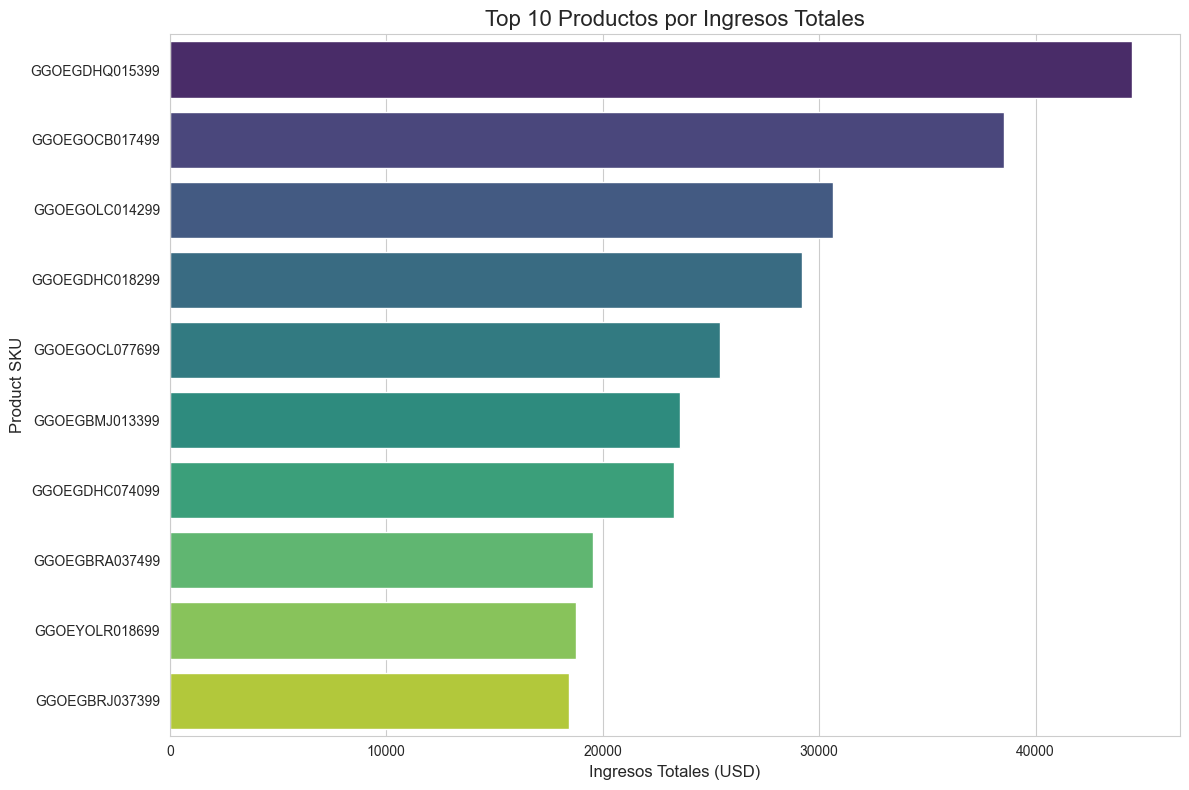

In [21]:
# Un gráfico de barras es más adecuado para comparar los ingresos totales de los 10 productos principales.

# Calcular el top 10 de productos por ingresos
top_10_revenue = df.groupby('product_sku')['total_product_revenue_usd'].sum().nlargest(10)

# Crear un gráfico de barras horizontales para una mejor visualización
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_revenue.values, y=top_10_revenue.index, orient='h', palette='viridis')
plt.title('Top 10 Productos por Ingresos Totales', fontsize=16)
plt.xlabel('Ingresos Totales (USD)', fontsize=12)
plt.ylabel('Product SKU', fontsize=12)
plt.tight_layout()
plt.show()